# Model Implementation

## Initialize Packages

In [101]:
import sys
import pandas as pd
import numpy as np
import os
import rich
import xgboost as xgb
import json
import joblib
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score, mean_tweedie_deviance
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint

In [102]:
parent_dir = os.path.abspath("..")
sys.path.append(parent_dir)

from analysis_tool_chest.data_exploration import PredictivenessCheck
from analysis_tool_chest.model_selection import ModelEvaluation

## Load Data and Assign Predictors

In [103]:
model_data = pd.read_csv('../backend/model_data.csv')
final_model_data = pd.read_csv('../backend/train_df_final.csv')
final_model_val_data = pd.read_csv('../backend/val_df_final.csv')

In [21]:
final_model_data['claim_cst_per_exposure'] = final_model_data['claimcst0'] / final_model_data['exposure']
final_model_data.head(5)

,id,driving_history_score,credit_score,low_education_ind,marital_status,time_driven,area,agecat_grouped,gender,veh_color,max_power,engine_type,veh_age,veh_body_grouped,veh_value,claimcst0,numclaims,clm,exposure,claim_cst_per_exposure
0,1,73.0,646.516469,0.0,0.0,1.0,1.0,2.0,0.0,0.0,161,2.0,2,7.0,5.80,2023.198184,1,1,0.362191,5585.998969
1,2,88.0,635.400369,0.0,1.0,2.0,0.0,1.0,0.0,4.0,100,0.0,4,6.0,5.67,3600.172234,1,1,0.632068,5695.859540
2,3,55.0,646.463131,0.0,0.0,2.0,2.0,1.0,0.0,3.0,74,3.0,2,5.0,5.90,2021.144067,1,1,0.367460,5500.307127
3,4,98.0,645.598794,0.0,0.0,3.0,1.0,1.0,1.0,0.0,121,0.0,3,6.0,4.79,4006.845492,1,1,0.802184,4994.920513
4,5,66.0,657.348612,0.0,1.0,2.0,2.0,2.0,1.0,1.0,75,3.0,3,5.0,6.68,2542.953931,1,1,0.485009,5243.106060


In [25]:
final_model_val_data['claim_cst_per_exposure'] = final_model_val_data['claimcst0'] / final_model_val_data['exposure']
final_model_val_data.head()

,id,driving_history_score,credit_score,low_education_ind,marital_status,time_driven,area,agecat_grouped,gender,veh_color,max_power,engine_type,veh_age,veh_body_grouped,veh_value,claimcst0,numclaims,clm,exposure,claim_cst_per_exposure
0,10,74.0,648.136355,0.0,0.0,1.0,1.0,1.0,0.0,1.0,267,0.0,4,8.0,6.49,3906.881054,1,1,0.746884,5230.906470
1,14,59.0,654.686205,0.0,1.0,2.0,3.0,1.0,1.0,1.0,129,1.0,3,5.0,6.56,4260.552605,1,1,0.848036,5024.022799
2,15,62.0,642.842943,0.0,0.0,2.0,2.0,2.0,1.0,3.0,122,3.0,2,5.0,6.09,2056.330796,1,1,0.356544,5767.397041
3,19,83.0,655.733899,0.0,1.0,2.0,1.0,1.0,1.0,1.0,115,3.0,4,5.0,7.13,4756.658716,1,1,0.896206,5307.551484
4,25,63.0,642.523923,0.0,1.0,1.0,0.0,1.0,1.0,3.0,183,3.0,3,7.0,6.37,2347.028119,1,1,0.401096,5851.538632


In [26]:
# Define the list of predictors
# Create predictor list
veh_pred_lst = ['veh_value', 'veh_body_grouped', 'veh_age', 'engine_type', 'max_power', 'veh_color']
policy_pred_lst = ['gender', 'agecat', 'e_bill' ]
driving_behavior_pred_lst = ['area', 'time_of_week_driven', 'time_driven']
demo_pred_lst = ['marital_status', 'low_education_ind', 'credit_score', 'driving_history_score']
pred_lst = veh_pred_lst + policy_pred_lst + driving_behavior_pred_lst + demo_pred_lst # Split the data into training and validation sets
# pred_lst = ['engine_type', 'gender', 'credit_score', 'veh_age', 'agecat', 'area']

train_data = model_data.loc[model_data['sample'] == '1|bld']
val_data = model_data.loc[model_data['sample'] == '2|val']
rich.print( train_data.shape, val_data.shape )
train_data.head(5)

(11204, 25)
(3796, 25)

,id,fold,sample,veh_value,exposure,veh_body,veh_age,gender,area,agecat,...,e_bill,time_of_week_driven,time_driven,trm_len,credit_score,low_education_ind,clm,numclaims,claimcst0,expected_loss
0,1,2,1|bld,5.80,0.362191,suv,2,f,b,1,...,0,weekday,12pm - 6pm,6,646.516469,0.0,1,1,2023.198184,5585.998969
1,2,3,1|bld,5.67,0.632068,stnwg,4,f,a,2,...,0,weekend,6am - 12pm,12,635.400369,0.0,1,1,3600.172234,5695.859540
2,3,1,1|bld,5.90,0.367460,sedan,2,f,c,2,...,0,weekday,6am - 12pm,12,646.463131,0.0,1,1,2021.144067,5500.307127
3,4,2,1|bld,4.79,0.802184,stnwg,3,m,b,4,...,1,weekday,6pm - 12am,12,645.598794,0.0,1,1,4006.845492,4994.920513
4,5,2,1|bld,6.68,0.485009,sedan,3,m,c,1,...,0,weekday,6am - 12pm,12,657.348612,0.0,1,1,2542.953931,5243.106060


In [27]:
target = 'claim_cst_per_exposure' 

# Use the full list of predictors you defined earlier for consistency
final_preds = [
    'driving_history_score', 'credit_score', 'marital_status',
    'time_driven', 'area', 'agecat_grouped', 'gender', 'veh_color',
    'max_power', 'engine_type', 'veh_age', 'veh_body_grouped', 'veh_value'
]

# Define X and y using the fully processed data file
X = final_model_data[final_preds].copy()
y = final_model_data[target]
exposure = final_model_data['exposure'].astype(float).clip(lower=1e-12)

print(f"Target variable set to: {target}")
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")

Target variable set to: claim_cst_per_exposure
X shape: (11204, 13)
y shape: (11204,)


# XGBoost

In [28]:
# --- Define Final Predictor List ---
pred_lst = [
    'low_education_ind',
    'driving_history_score',
    'credit_score',
    'marital_status',
    'time_driven',
    'area',
    'agecat_grouped', 
    'gender',
    'veh_color',
    'max_power',
    'engine_type',
    'veh_age',
    'veh_body_grouped', 
    'veh_value'
]

# Define X and Y using the final list
X_train = final_model_data[pred_lst].copy()
X_val = final_model_val_data[pred_lst].copy()
y_train = final_model_data[target]
y_val = final_model_val_data[target]

# Redefine Num and Cat columns for the new list 
num_cols = ['driving_history_score', 'credit_score', 'max_power', 'veh_value']
cat_cols = [col for col in X_train.columns if col not in num_cols]

In [40]:
# 1. Create DMatrix (using the newly processed cleaned data)
dtrain = xgb.DMatrix(X_train, label=y_train)

# 2. Define Parameters for XGBoost
params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'eta': 0.05,
    'max_depth': 5,
    'seed': 42
}

# 3. Perform Cross-Validation to Find Optimal n_estimators
cv_results = xgb.cv(
    params=params, # Use the defined Tweedie parameters
    dtrain=dtrain,
    num_boost_round=5000, # Max rounds
    nfold=5,  # 5-fold cross-validation
    early_stopping_rounds=50,
    seed=42,
    verbose_eval=50
)


# Extract the best number of rounds and performance
best_n_estimators = cv_results.shape[0]
best_rmse = cv_results['test-rmse-mean'].min()
best_num_boost_round = len(cv_results)

print(f"Optimal n_estimators: {best_n_estimators}")
print(f"CV Test RMSE: {best_rmse:.4f}")

# 4. Train the Final Model on the entire training set
xgb_model_base = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=best_n_estimators
)
print("Final model training with cleaned data complete.")

[0]	train-rmse:3553.34259+68.65837	test-rmse:3551.59773+274.15010
[50]	train-rmse:3323.25249+64.73663	test-rmse:3538.38768+280.31994
[67]	train-rmse:3272.04607+65.54322	test-rmse:3539.72978+280.14733
Optimal n_estimators: 18
CV Test RMSE: 3537.4914
Final model training with cleaned data complete.


In [41]:
#Define objects (assuming X_train_processed and y_train are available)
xgb_model_rs = xgb.XGBRegressor(
    objective='reg:squarederror', random_state=42, n_jobs=-1, eval_metric='rmse' 
)
param_dist = {
    'n_estimators': randint(100, 1000), 'max_depth': randint(3, 10),                    
    'learning_rate': uniform(0.01, 0.2), 'subsample': uniform(0.6, 0.4),                 
    'colsample_bytree': uniform(0.6, 0.4), 'gamma': uniform(0, 0.5),                       
    'reg_alpha': uniform(0, 0.5),                   
}
random_search = RandomizedSearchCV(
    estimator=xgb_model_rs, param_distributions=param_dist, n_iter=50,
    scoring='neg_root_mean_squared_error', cv=5, random_state=42, verbose=1, n_jobs=-1
)

print("\nStarting NEW Randomized Hyperparameter Search for 'claimscst0'...")
random_search.fit(X_train, y_train)

#Extract results
best_params = random_search.best_params_
best_rmse_tuned_claimcost = -random_search.best_score_ 
best_n_estimators = best_params.pop('n_estimators') # Extract n_estimators separately

print("\n--- Hyperparameter Tuning Results for claimscst0 ---")
print(f"Tuned CV RMSE (claimscst0): {best_rmse_tuned_claimcost:.4f}")
print(f"Best n_estimators: {best_n_estimators}")
print("\nBest Other Parameters Found:")
for k, v in best_params.items():
    print(f"  {k}: {v:.4f}" if isinstance(v, float) else f"  {k}: {v}")


Starting NEW Randomized Hyperparameter Search for 'claimscst0'...
Fitting 5 folds for each of 50 candidates, totalling 250 fits

--- Hyperparameter Tuning Results for claimscst0 ---
Tuned CV RMSE (claimscst0): 2679.2734
Best n_estimators: 114

Best Other Parameters Found:
  colsample_bytree: 0.6944
  gamma: 0.1280
  learning_rate: 0.0181
  max_depth: 9
  reg_alpha: 0.0554
  subsample: 0.7757


In [42]:
#Define final model parameters (using the best parameters found)
final_params = {
    'objective': 'reg:squarederror', 'eval_metric': 'rmse', 'seed': 42,
    'eta': best_params['learning_rate'], 'max_depth': best_params['max_depth'],
    'subsample': best_params['subsample'], 'colsample_bytree': best_params['colsample_bytree'],
    'gamma': best_params['gamma'], 'reg_alpha': best_params['reg_alpha']
}

print(f"\nTraining FINAL model with {best_n_estimators} estimators...")
#Defining the model with the correct variable name
model = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=best_num_boost_round
)


Training FINAL model with 114 estimators...


<Figure size 1000x800 with 0 Axes>

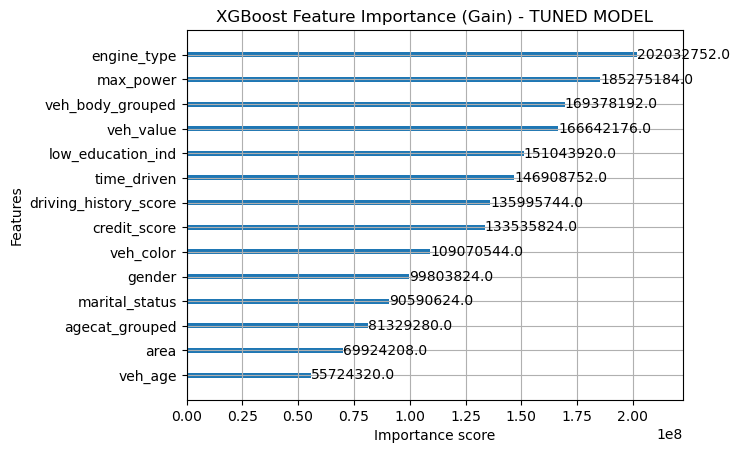


## Top 15 Features by Importance (Gain) - TUNED MODEL:
              Feature  Importance (Gain)
          engine_type        202032752.0
            max_power        185275184.0
     veh_body_grouped        169378192.0
            veh_value        166642176.0
    low_education_ind        151043920.0
          time_driven        146908752.0
driving_history_score        135995744.0
         credit_score        133535824.0
            veh_color        109070544.0
               gender         99803824.0
       marital_status         90590624.0
       agecat_grouped         81329280.0
                 area         69924208.0
              veh_age         55724320.0


In [43]:
# 1. Get feature importance scores using the FINAL TUNED MODEL
importance = model.get_score(importance_type='gain')

# 2. Convert to DataFrame and sort for plotting
importance_df = pd.DataFrame(
    list(importance.items()), 
    columns=['Feature', 'Importance (Gain)']
).sort_values(by='Importance (Gain)', ascending=False)

# 3. Plot the top 15 features
plt.figure(figsize=(10, 8))
try:
    xgb.plot_importance(
        model, 
        importance_type='gain', 
        max_num_features=15, 
        title='XGBoost Feature Importance (Gain) - TUNED MODEL'
    )
    plt.show()
except Exception:
    print("Could not plot feature importance directly. Displaying table instead.")
    
# Display the top 15 most important features
print("\n## Top 15 Features by Importance (Gain) - TUNED MODEL:")
print(importance_df.head(15).to_string(index=False))

In [44]:
# 1. Generate predictions using the final tuned model
predictions_train = model.predict(dtrain)

# --- 2. Calculate Base Metrics ---
# Calculate the RMSE (Root Mean Square Error)
rmse_train = np.sqrt(np.mean((y_train - predictions_train)**2))


# --- 3. Clipping for Tweedie Requirement (y > 0 and y_pred > 0) ---
CLIP_VALUE = 1e-6 
y_clipped = np.clip(y_train, a_min=CLIP_VALUE, a_max=None)
predictions_train_clipped = np.clip(predictions_train, a_min=CLIP_VALUE, a_max=None)

# --- 4. Calculate Advanced Metrics ---
# Gini Coefficient
me = ModelEvaluation(y_clipped, predictions_train_clipped) 
gini = me.gini()

# MAE (Mean Absolute Error)
mae_train = mean_absolute_error(y_clipped, predictions_train_clipped)

# Tweedie Deviance (using power=1.0 for Poisson/Claim Count alignment)
tweedie_dev_train = mean_tweedie_deviance(
    y_true=y_clipped, 
    y_pred=predictions_train_clipped, 
    power=1.0
)

# --- 5. Print Results ---
print(f"\n--- Final Model Evaluation on TRAINING Set (Claim Cost) ---")
print(f"Training RMSE: {rmse_train:.4f}")
print(f"Training Gini Coefficient: {gini:.4f} (Ranking Power)")
print(f"Training MAE: {mae_train:.2f} (Average Dollar Error)")


--- Final Model Evaluation on TRAINING Set (Claim Cost) ---
Training RMSE: 3469.0051
Training Gini Coefficient: 0.5238 (Ranking Power)
Training MAE: 1454.95 (Average Dollar Error)


In [45]:
exposure_val = val_data['exposure'].astype(float).clip(lower=1e-12)

dval = xgb.DMatrix(
    X_val,
    label=y_val,
    base_margin=np.log(exposure_val)   # log exposure offset
)

In [46]:
# 1. Generate predictions using the final tuned model
predictions_val = model.predict(dval)

# --- 2. Calculate Base Metrics ---
r_squared_val = r2_score(y_val, predictions_val)
rmse_val = np.sqrt(np.mean((y_val - predictions_val)**2))

# --- 3. Clipping for Metrics (Required for Tweedie/Gini) ---
CLIP_VALUE = 1e-6
y_val_clipped = np.clip(y_val, a_min=CLIP_VALUE, a_max=None)
predictions_val_clipped = np.clip(predictions_val, a_min=CLIP_VALUE, a_max=None)

# --- 4. Calculate Advanced Metrics ---
# Gini Coefficient
me_val = ModelEvaluation(y_val_clipped, predictions_val_clipped) 
gini_val = me_val.gini()

# MAE (Mean Absolute Error)
mae_val = mean_absolute_error(y_val_clipped, predictions_val_clipped)

# Tweedie Deviance (using power=1.0 for Claim Cost)
tweedie_dev_val = mean_tweedie_deviance(
    y_true=y_val_clipped, 
    y_pred=predictions_val_clipped, 
    power=1.0
)

# --- 5. Print Results & Check for Overfitting ---
print(f"\n--- Final Model Evaluation on VALIDATION Set (Claim Cost) ---")
print(f"Validation Gini Coefficient: {gini_val:.4f} (Ranking Power)")
print(f"Validation RMSE: {rmse_val:.4f}")
print(f"Validation MAE: {mae_val:.2f}")


--- Final Model Evaluation on VALIDATION Set (Claim Cost) ---
Validation Gini Coefficient: 0.5392 (Ranking Power)
Validation RMSE: 3571.8436
Validation MAE: 840.70


## Save Altered Data

In [ ]:
model_data.to_csv('../project/model_data.csv', index=False)